In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def generate_synthetic_data():
    print("Generating synthetic energy data...")
    # Create date range for 6 months: Jan 2023 to June 2023
    date_rng = pd.date_range(start='1/1/2023', end='6/30/2023', freq='H')
    
    # Create DataFrame
    df = pd.DataFrame(date_rng, columns=['timestamp'])
    
    # Simulate device power consumption (Watts)
    
    # 1. Fridge: Cyclic pattern (Compressor On/Off) + Base load
    # Randomly switching between low (idle) and high (cooling) states
    df['fridge'] = np.random.randint(50, 200, size=(len(date_rng))) * np.random.choice([0, 1], size=len(date_rng), p=[0.3, 0.7])
    
    # 2. AC: Higher in summer (April-June), lower in winter (Jan-March)
    month = df['timestamp'].dt.month
    # Higher probability of AC being ON in months 4, 5, 6
    ac_prob = np.where(month >= 4, 0.8, 0.1) 
    df['ac'] = np.random.randint(1000, 2500, size=(len(date_rng))) * np.random.binomial(1, ac_prob)
    
    # 3. Lights: Higher usage at night (18:00 - 06:00)
    hour = df['timestamp'].dt.hour
    light_prob = np.where((hour >= 18) | (hour <= 6), 0.9, 0.1)
    df['lights'] = np.random.randint(20, 100, size=(len(date_rng))) * np.random.binomial(1, light_prob)
    
    # 4. Microwave: Random usage spikes
    df['microwave'] = np.random.randint(800, 1200, size=(len(date_rng))) * np.random.choice([0, 1], size=len(date_rng), p=[0.95, 0.05])
    
    # Total power consumption
    df['total_power'] = df['fridge'] + df['ac'] + df['lights'] + df['microwave']
    
    # Introduce some random missing values to practice cleaning
    # Set 0.5% of total_power to NaN
    mask = np.random.choice([True, False], size=len(df), p=[0.005, 0.995])
    df.loc[mask, 'total_power'] = np.nan
    
    return df

# Generate and save
df_raw = generate_synthetic_data()
print("Data Generated. Shape:", df_raw.shape)
df_raw.to_csv()

In [25]:
df_raw.columns

Index(['timestamp', 'fridge', 'ac', 'lights', 'microwave', 'total_power'], dtype='object')

In [26]:
df_raw.to_csv("Synthetic-Data",index=True)
df_raw.iloc[:30]
df_raw

,timestamp,fridge,ac,lights,microwave,total_power
0,2023-01-01 00:00:00,0,0,28,0,28.0
1,2023-01-01 01:00:00,119,0,84,0,203.0
2,2023-01-01 02:00:00,135,0,47,0,182.0
3,2023-01-01 03:00:00,171,0,21,0,192.0
4,2023-01-01 04:00:00,0,0,88,0,88.0
...,...,...,...,...,...,...
4316,2023-06-29 20:00:00,146,2221,23,0,2390.0
4317,2023-06-29 21:00:00,72,1887,31,0,1990.0
4318,2023-06-29 22:00:00,156,1982,0,0,2138.0
4319,2023-06-29 23:00:00,149,1143,43,0,1335.0


In [27]:
missing = df_raw.isnull().sum()
print("Missing Values per column:\n", missing)

Missing Values per column:
 timestamp       0
fridge          0
ac              0
lights          0
microwave       0
total_power    29
dtype: int64


In [28]:
df_raw[df_raw['total_power'].isna()].index

Index([  46,   54,   95,  332,  374,  378,  868, 1154, 1293, 1388, 1702, 1722,
       2008, 2080, 2182, 2305, 2318, 2546, 2943, 2970, 3005, 3094, 3188, 3209,
       3694, 3922, 3930, 3951, 4030],
      dtype='int64')

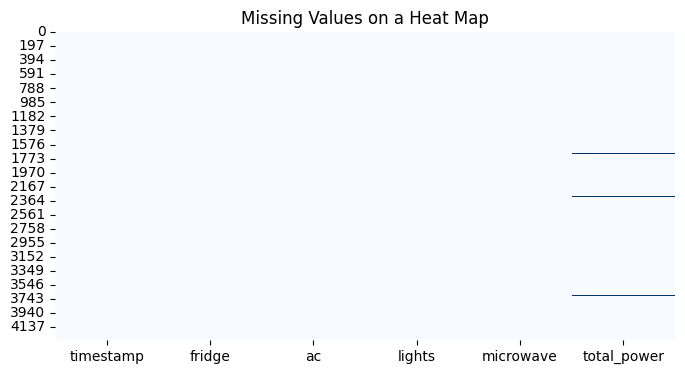

In [29]:
plt.figure(figsize=(8,4))
sns.heatmap(df_raw.isnull(),cbar=False,cmap='Blues')
plt.title("Missing Values on a Heat Map")
plt.show()

In [34]:
df_clean = df_raw.ffill()
df_clean.to_csv("Clean-Data.csv", index=False)

In [35]:
df_clean[df_clean['total_power'].isna()].index

Index([], dtype='int64')

In [36]:
print(df_clean.head())
print(df_clean.index)

            timestamp  fridge  ac  lights  microwave  total_power
0 2023-01-01 00:00:00       0   0      28          0         28.0
1 2023-01-01 01:00:00     119   0      84          0        203.0
2 2023-01-01 02:00:00     135   0      47          0        182.0
3 2023-01-01 03:00:00     171   0      21          0        192.0
4 2023-01-01 04:00:00       0   0      88          0         88.0
RangeIndex(start=0, stop=4321, step=1)


In [37]:
print(df_clean.columns)

Index(['timestamp', 'fridge', 'ac', 'lights', 'microwave', 'total_power'], dtype='object')


In [38]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

In [39]:
print(df_clean.index)
print(df_clean.dtypes)

RangeIndex(start=0, stop=4321, step=1)
timestamp      datetime64[ns]
fridge                  int64
ac                      int32
lights                  int32
microwave               int64
total_power           float64
dtype: object


In [40]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], errors='coerce')
df_clean = df_clean.dropna(subset=['timestamp'])
df_clean = df_clean.set_index('timestamp')
df_clean = df_clean.sort_index()

In [41]:
df_daily = df_clean.resample('D').mean()
df_weekly_sum = df_clean.resample('W').sum()
print("Daily resampled Shape:", df_daily.shape)
print("Weekly resampled Shape:", df_weekly_sum.shape)

Daily resampled Shape: (181, 5)
Weekly resampled Shape: (27, 5)


In [42]:
df = pd.read_csv('Clean-Data')
df

,timestamp,fridge,ac,lights,microwave,total_power
0,2023-01-01 00:00:00,0,0,28,0,28.0
1,2023-01-01 01:00:00,119,0,84,0,203.0
2,2023-01-01 02:00:00,135,0,47,0,182.0
3,2023-01-01 03:00:00,171,0,21,0,192.0
4,2023-01-01 04:00:00,0,0,88,0,88.0
...,...,...,...,...,...,...
4316,2023-06-29 20:00:00,146,2221,23,0,2390.0
4317,2023-06-29 21:00:00,72,1887,31,0,1990.0
4318,2023-06-29 22:00:00,156,1982,0,0,2138.0
4319,2023-06-29 23:00:00,149,1143,43,0,1335.0


In [43]:
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df['timestamp']

0      2023-01-01 00:00:00
1      2023-01-01 01:00:00
2      2023-01-01 02:00:00
3      2023-01-01 03:00:00
4      2023-01-01 04:00:00
               ...        
4316   2023-06-29 20:00:00
4317   2023-06-29 21:00:00
4318   2023-06-29 22:00:00
4319   2023-06-29 23:00:00
4320   2023-06-30 00:00:00
Name: timestamp, Length: 4321, dtype: datetime64[ns]

In [44]:
df_daily.to_csv('timed-data',index=True)
df_daily.head()

,fridge,ac,lights,microwave,total_power
timestamp,,,,,
2023-01-01,97.125000,0.000000,42.125000,0.000000,139.250000
2023-01-02,61.875000,171.041667,31.250000,49.333333,312.083333
2023-01-03,107.375000,200.625000,25.833333,0.000000,332.583333
2023-01-04,65.166667,142.791667,33.791667,34.375000,279.250000
2023-01-05,98.833333,224.583333,32.875000,85.916667,442.208333


In [45]:
df_weekly_sum

,fridge,ac,lights,microwave,total_power
timestamp,,,,,
2023-01-01,2331,0,1011,0,3342.0
2023-01-08,13992,30212,5555,7338,57108.0
2023-01-15,13447,27244,5360,11882,57950.0
2023-01-22,13677,35009,4733,11312,64709.0
2023-01-29,14546,20029,5193,7853,47621.0
2023-02-05,14716,20361,5535,7760,48372.0
2023-02-12,15231,24167,5864,7240,53482.0
2023-02-19,15101,21170,5515,10928,52880.0
2023-02-26,13995,33019,5506,8522,61075.0


In [46]:
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

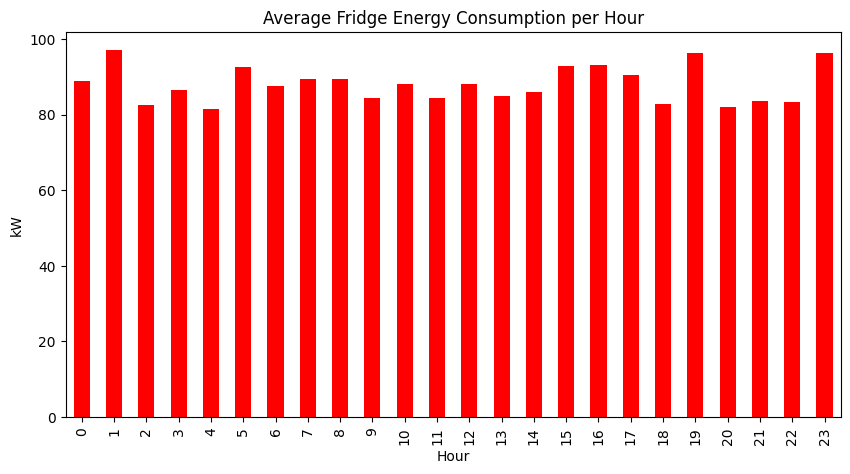

In [47]:
hourly_stats = df.groupby('hour')['fridge'].mean()
plt.figure(figsize=(10,5))
hourly_stats.plot(kind='bar', color='red')
plt.title("Average Fridge Energy Consumption per Hour")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.show()

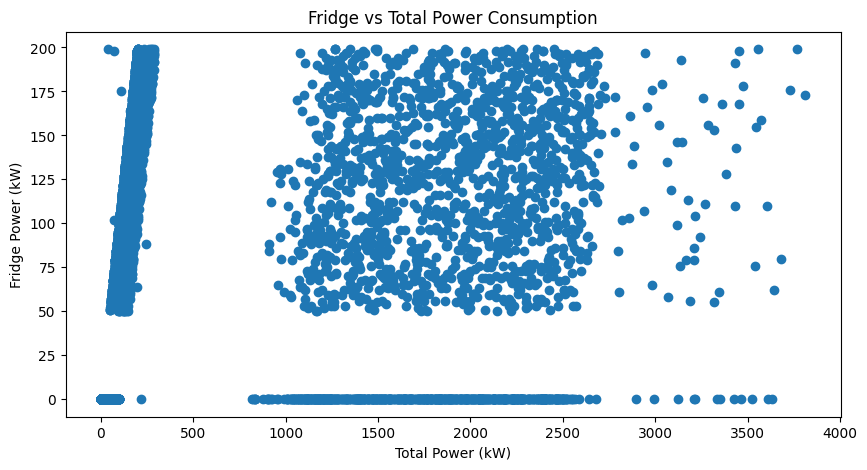

In [48]:
plt.figure(figsize=(10,5))
plt.scatter(df['total_power'], df['fridge'])
plt.title("Fridge vs Total Power Consumption")
plt.xlabel("Total Power (kW)")
plt.ylabel("Fridge Power (kW)")
plt.show()

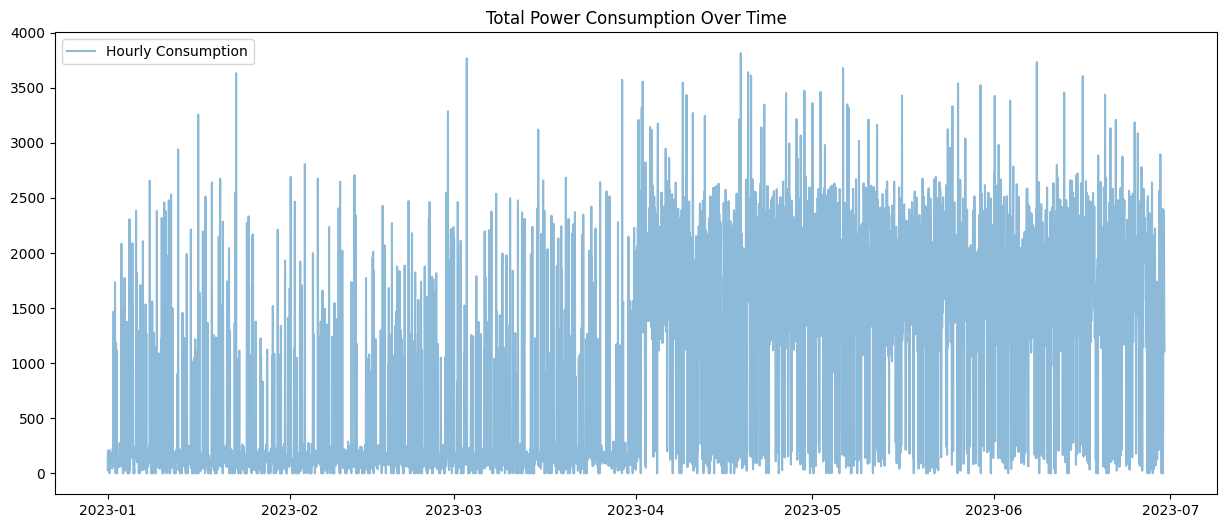

In [49]:
plt.figure(figsize=(15,6))
plt.plot(df_clean.index, df_clean['total_power'], label='Hourly Consumption',alpha=0.5)
plt.title("Total Power Consumption Over Time")
plt.legend()
plt.show()

In [53]:
avg_consumption = df_clean[['fridge', 'ac', 'microwave','lights']].mean()
avg_consumption

fridge        87.996760
ac           808.696367
microwave     50.059477
lights        31.922703
dtype: float64

C:\Users\adhee\AppData\Local\Temp\ipykernel_19464\3014722625.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


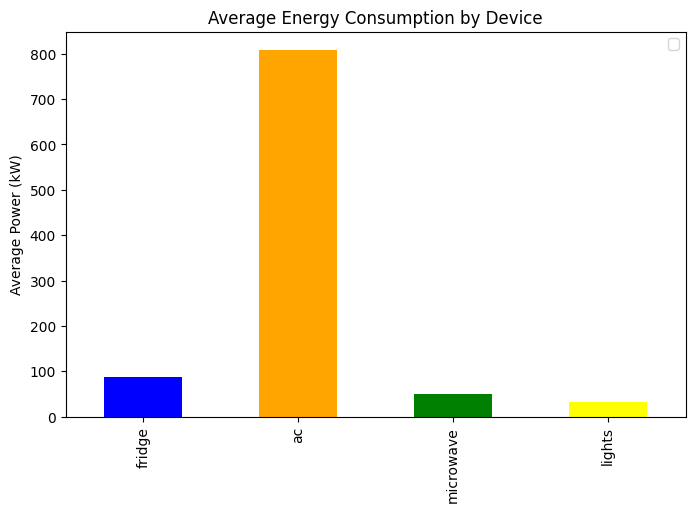

In [54]:
plt.figure(figsize=(8,5))
avg_consumption.plot(kind='bar', color=['blue', 'orange', 'green','yellow'])
plt.title("Average Energy Consumption by Device")
plt.ylabel("Average Power (kW)")
plt.legend()
plt.show()

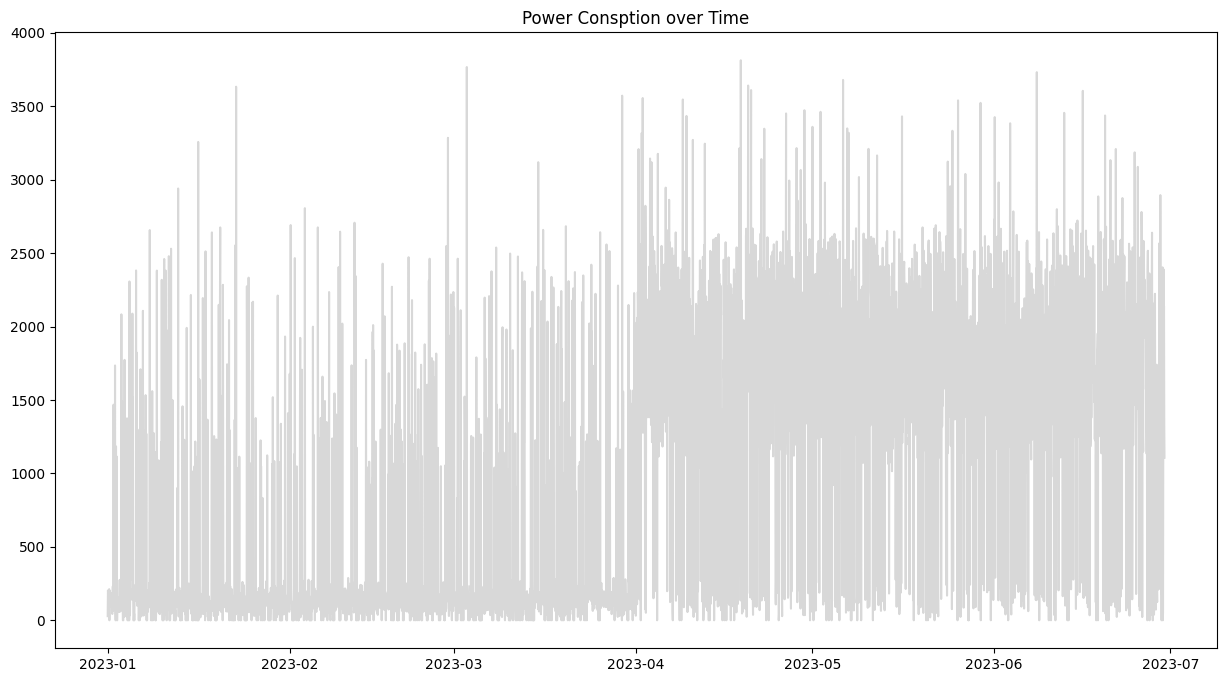

In [56]:
plt.figure(figsize=(15,8))
plt.plot(df_clean.index, df_clean['total_power'],alpha=0.3,color = "gray", label = "Power Consumption Hourly") 
plt.title("Power Consption over Time")
plt.show()